In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pandas import DataFrame
from tqdm import tqdm
from sklearn.utils import check_random_state
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.style.use('ggplot')
y_label_dict = {"se": "左図：平均二乗誤差", "bias": "中図：二乗バイアス", "variance": "右図：バリアンス"}

from dataset import generate_synthetic_data, calc_true_value
from estimators import calc_avg, calc_ips, calc_mips
from utils import eps_greedy_policy, aggregate_simulation_results, remove_outliers

In [ ]:
def calc_mips(
    dataset: dict,
    pi: np.ndarray,
    replace_c: int = 0,
    is_estimate_w: bool = False,
) -> float:
    """MIPS推定量を実行する."""
    num_data = dataset["num_data"]
    num_actions, num_clusters = dataset["num_actions"], dataset["num_clusters"]
    x, a, c, r = dataset["x"], dataset["a"], copy(dataset["c"]), dataset["r"]
    pi_0, phi_a = dataset["pi_0"], copy(dataset["phi_a"])
    min_value, max_value = r.min(), r.max()

    if replace_c > 0:
        c[c >= num_clusters - replace_c] = num_clusters - replace_c - 1
        phi_a[phi_a >= num_clusters - replace_c] = num_clusters - replace_c - 1

    if is_estimate_w:
        x_c = np.c_[x, np.eye(num_clusters)[c]]
        pi_a_x_c_model = LogisticRegression(C=5, random_state=12345)
        pi_a_x_c_model.fit(x_c, a)

        w_x_a_full = pi / pi_0
        pi_a_x_c_hat = np.zeros((num_data, num_actions))
        pi_a_x_c_hat[:, np.unique(a)] = pi_a_x_c_model.predict_proba(x_c)
        w_x_c_hat = (pi_a_x_c_hat * w_x_a_full).sum(1)

        return np.clip((w_x_c_hat * r).mean(), min_value, max_value)

    else:
        pi_0_c = np.zeros((num_data, num_clusters - replace_c))
        pi_c = np.zeros((num_data, num_clusters - replace_c))
        for c_ in range(num_clusters - replace_c):
            pi_0_c[:, c_] = pi_0[:, phi_a == c_].sum(1)
            pi_c[:, c_] = pi[:, phi_a == c_].sum(1)

        # 周辺重要度重み
        w_x_c = pi_c[np.arange(num_data), c] / pi_0_c[np.arange(num_data), c]

        return np.clip((w_x_c * r).mean(), min_value, max_value)

In [67]:
import numpy as np
from sklearn.utils import check_random_state

from utils import sample_action_fast, softmax, eps_greedy_policy


def generate_synthetic_data(
    num_data: int,
    theta_g: np.ndarray,
    M_g: np.ndarray,
    b_g: np.ndarray,
    theta_h: np.ndarray,
    M_h: np.ndarray,
    b_h: np.ndarray,
    phi_a: np.ndarray,
    lambda_: float = 0.5,
    dim_context: int = 5,
    num_actions: int = 50,
    num_def_actions: int = 0,
    num_clusters: int = 3,
    beta: float = -3.0,
    random_state: int = 12345,
) -> dict:
    """行動特徴量を活用したオフ方策評価におけるログデータを生成する."""
    random_ = check_random_state(random_state)
    x = random_.normal(size=(num_data, dim_context))
    one_hot_a, one_hot_c = np.eye(num_actions), np.eye(num_clusters)

    # 期待報酬関数を定義する
    g_x_c = (
        (x - x ** 2) @ theta_g + (x ** 3 + x ** 2 - x) @ M_g @ one_hot_c + b_g
    ) / 10
    h_x_a = (
        (x ** 3 + x ** 2 - x) @ theta_h + (x - x ** 2) @ M_h @ one_hot_a + b_h
    ) / 10
    q_x_a = (1 - lambda_) * g_x_c[:, phi_a] + lambda_ * h_x_a

    # データ収集方策を定義する
    pi_0 = softmax(beta * q_x_a)
    pi_0[:, :num_def_actions] = 0 #特定の行動の確率を 0 に設定
    pi_0 = pi_0 / pi_0.sum(1)[:, np.newaxis]  #pi_0 の確率が適切に合計 1 になるよう調整 
    #pi_0 の一部の要素を 0 に変更したため、その影響を補正するための処理。

    # 行動や報酬を抽出する
    a = sample_action_fast(pi_0, random_state=random_state)
    q_x_a_factual = q_x_a[np.arange(num_data), a]
    r = random_.normal(q_x_a_factual)

    return dict(
        num_data=num_data,
        num_actions=num_actions,
        num_clusters=num_clusters,
        x=x,
        a=a,
        c=phi_a[a],
        r=r,
        phi_a=phi_a,
        pi_0=pi_0,
        g_x_c=(1 - lambda_) * g_x_c,
        h_x_a=lambda_ * h_x_a,
        q_x_a=q_x_a,
    )


def calc_true_value(
    dim_context: int,
    num_actions: int,
    num_clusters: int,
    theta_g: np.ndarray,
    M_g: np.ndarray,
    b_g: np.ndarray,
    phi_a: np.ndarray,
    theta_h: np.ndarray,
    M_h: np.ndarray,
    b_h: np.ndarray,
    lambda_: float,
) -> float:
    """評価方策の真の性能を近似する."""
    test_bandit_data = generate_synthetic_data(
        num_data=10000,
        dim_context=dim_context,
        num_actions=num_actions,
        num_clusters=num_clusters,
        theta_g=theta_g,
        M_g=M_g,
        b_g=b_g,
        theta_h=theta_h,
        M_h=M_h,
        b_h=b_h,
        lambda_=lambda_,
        phi_a=phi_a,
    )

    q_x_a = test_bandit_data["q_x_a"]
    pi = eps_greedy_policy(q_x_a)

    return (q_x_a * pi).sum(1).mean()


In [68]:
## シミュレーション設定
num_runs = 5000 # シミュレーションの繰り返し回数
dim_context = 5 # 特徴量xの次元
num_clusters = 30 # 行動クラスタ数
num_data = 500 # ログデータのサイズ
beta = -0.2 # データ収集方策のパラメータ
lambda_ = 0.0 # クラスタ効果と残差効果の配合率
random_state = 12345
random_ = check_random_state(random_state)
num_actions_list = [250, 500, 1000, 2000, 4000] # 行動数, |A|
num_actions = 200

In [69]:
theta_g = random_.normal(size=(dim_context, num_clusters))
M_g = random_.normal(size=(dim_context, num_clusters))
b_g = random_.normal(size=(1, num_clusters))

In [70]:
phi_a = random_.choice(num_clusters, size=num_actions)
theta_h = random_.normal(size=(dim_context, num_actions))
M_h = random_.normal(size=(dim_context, num_actions))
b_h = random_.normal(size=(1, num_actions))

In [71]:
phi_a.shape

(200,)

In [72]:
offline_logged_data = generate_synthetic_data(
            num_data=num_data, lambda_=lambda_, beta=beta,
            theta_g=theta_g, M_g=M_g, b_g=b_g, theta_h=theta_h, M_h=M_h, b_h=b_h, phi_a=phi_a,
            dim_context=dim_context, num_actions=num_actions, num_clusters=num_clusters, random_state = 12
        )

In [73]:
random_ = check_random_state(random_state)
x = random_.normal(size=(num_data, dim_context))
one_hot_a, one_hot_c = np.eye(num_actions), np.eye(num_clusters)

# 期待報酬関数を定義する
g_x_c = (
        (x - x ** 2) @ theta_g + (x ** 3 + x ** 2 - x) @ M_g @ one_hot_c + b_g
    ) / 10
h_x_a = (
        (x ** 3 + x ** 2 - x) @ theta_h + (x - x ** 2) @ M_h @ one_hot_a + b_h
    ) / 10
q_x_a = (1 - lambda_) * g_x_c[:, phi_a] + lambda_ * h_x_a

In [74]:
print(g_x_c.shape)
print(h_x_a.shape)

(500, 30)
(500, 200)


In [75]:
print(phi_a)

[20 13 16 29 24  3 14 19 27 25 11 12 17 21 20 24 23 25 22 21  6 29 11 17
 22 13 15 14 16  5 12  1 21  1 22 20 22 28 26 25 13 19 29  5 25 18 16 11
  7 14 19  8 25  0  1 11 13 10 25 14 17 26  0  9  7 13 16  7  2 19 23 14
  9  1 17 29 15 14  9 16  6 24 22 21  4  1 27 20  8 11 16 19  1  4 13 29
 23 25  0 23  8 29 10  2  1 10  7 19 18  0 14 26 12  4 12 29 22 17 28 24
 10 24 27 18 15  5 16  0 12  2 27 22 11  1  4  1 18  6 16 20 16 11 19 13
  7 18 24  8 24 14  5  4 16  3  9  6  0  3 10 11  5 21  6  7 28  7 24  9
 20 12 27  2 24  8 25 29  3  4 13 21 23 17 18 12 27  1 23 24 18 26 17  1
 11  9  4 16 14 14 20 25]


In [76]:
g_x_c[:, phi_a].shape

(500, 200)

In [77]:
a= np.array([[1,2,3],[4,5,6]])
b=np.array([2,0,1])
print(a[:,b])

[[3 1 2]
 [6 4 5]]


In [78]:
num_def_actions = 0
# データ収集方策を定義する
pi_0 = softmax(beta * q_x_a)
pi_0[:, :num_def_actions] = 0
pi_0 = pi_0 / pi_0.sum(1)[:, np.newaxis]

# 行動や報酬を抽出する
a = sample_action_fast(pi_0, random_state=random_state)
q_x_a_factual = q_x_a[np.arange(num_data), a]
r = random_.normal(q_x_a_factual)

In [79]:
print(offline_logged_data["phi_a"])
print(offline_logged_data["c"].shape)

[20 13 16 29 24  3 14 19 27 25 11 12 17 21 20 24 23 25 22 21  6 29 11 17
 22 13 15 14 16  5 12  1 21  1 22 20 22 28 26 25 13 19 29  5 25 18 16 11
  7 14 19  8 25  0  1 11 13 10 25 14 17 26  0  9  7 13 16  7  2 19 23 14
  9  1 17 29 15 14  9 16  6 24 22 21  4  1 27 20  8 11 16 19  1  4 13 29
 23 25  0 23  8 29 10  2  1 10  7 19 18  0 14 26 12  4 12 29 22 17 28 24
 10 24 27 18 15  5 16  0 12  2 27 22 11  1  4  1 18  6 16 20 16 11 19 13
  7 18 24  8 24 14  5  4 16  3  9  6  0  3 10 11  5 21  6  7 28  7 24  9
 20 12 27  2 24  8 25 29  3  4 13 21 23 17 18 12 27  1 23 24 18 26 17  1
 11  9  4 16 14 14 20 25]
(500,)


In [80]:
print(offline_logged_data["a"])

[ 31 143  52 106   2 183 180   6 191  25  54 121 188 170   0 105 111  97
 153  31 152   3  26  23  62 133  93 163  58 146 139  65  67 195 124 190
 153 165  81  89  79 199  33 192  83  84  92  77  94   7  16 146 127   5
  60  44  10 104  83   8 114 161  22  55 129  98 101  92 178 122 120  88
  95 177  41 188  14 119   6 133 127 172 187  88 132 184 124  64  64  58
 191  80 188 171 137   0 180 183   1 127  76 119 122 120  62  13 160 182
  38  41  78  80 177  39  83 129 102  66 155  23  37  80 157  51  21 186
  25 121  58 124 131  13  71  67  35   1   2 120  16  62 193 174 182  33
  60  47  95 109  80 148 128 131  30 148 129  57  73 197  67  67 123 124
   2 116 155 189 140  23  47  83 125  15  78  64 194 193 148 103  32 190
 184 176   9 155  20 180 117 197  84 125 155  51 127 164 104  84 106 189
 199 134 158 196  28   5 149 123  19 103 101  57  48  35 116  30 142 171
 137  52  78 102  67 109 137  60  42 157 155   8 129  25 108  57 165  19
 179  68  26  91  17 147  72  65  19  36 103  22  9

In [81]:
print(offline_logged_data["r"].shape)

(500,)


In [82]:
print(offline_logged_data["num_clusters"])

30


In [83]:
print(offline_logged_data["c"])

[ 1 13 25  7 16 12 23 14  1 13  1 24 18 27 20 10 26 25  3  1 16 29 15 17
  0  1  4  7 25 24 20 13  7 16 15 17  3  7 24 11 16 25  1 11 21  4  1 14
 13 19 23 24  0  3 17 25 11  1 21 27 12 21 11 11  2  0 29  1 13 27 10  8
 29  4 19 18 20 24 14  1  0 24 24  8 11 27 15  7  7 25  1  6 18  2  6 20
 23 12 13  0 15 24 27 10  0 21  5 18 26 19  9  6  4 25 21  2 10 16  6 17
 28  6  3  8 29 23 13 24 25 15 22 21 14  7 20 13 16 10 23  0  9 25 18  1
 17 11 29  0  6 24 12 22 12 24  2 10  1 14  7  7 18 15 16 22  6 26 16 17
 11 21  5 24  9  7  4  9 24  2 21 17 27  3 25  6  6 23 17 14  4  5  6  8
  0 28  1  4  7 26 25  4 10 14 16  3 14 18 21  2 29 10  7 20 22 12 19  2
  6 25  9 10  7  0  6 17 29  3  6 27  2 13 18 10  7 21 21  2 15 19 25  8
  9 13 21 22  2 11 23 23  9 20 21 11 18 22  2 13 29 29 18 16  8 22  9  9
 19 12  1  9 11 14 23 11 27 18 21  1 24 24 19 17  4 20 14 17 11 27 13  1
  2 16 24 29 13 10 16 12 18 24  0 21 10  5 16 11 24  9 12 17 22 10 10  4
 21  1  1  4 29 16 20 21  5 24 29  7  1  7  3 13 21

In [84]:
from copy import copy
from sklearn.linear_model import LogisticRegression

In [203]:
def calc_mips(
    dataset:dict, 
    pi:np.ndarray,
    replace_c:int = 0,
    is_estimate_w: bool = False
    ) ->float:
    """
    NEW_MIPS推定量

    """
    num_data = dataset["num_data"]
    num_actions, num_clusters = dataset["num_actions"], dataset["num_clusters"]
    x, a, c, r = dataset["x"], dataset["a"], copy(dataset["c"]), dataset["r"]
    pi_0, phi_a = dataset["pi_0"], copy(dataset["phi_a"])
    min_value, max_value = r.min(), r.max()
    
    if replace_c > 0:
        #replace_c個のクラスタをnum_clusters - replace_c - 1に結合
        c[c >= num_clusters - replace_c] = num_clusters - replace_c - 1
        phi_a[phi_a >= num_clusters - replace_c] = num_clusters - replace_c - 1

    if is_estimate_w:#p(a|e,x)の推定
        x_c = np.c_[x, np.eye(num_clusters)[c]]
        pi_a_x_c_model = LogisticRegression(C=5, random_state=12345)
        pi_a_x_c_model.fit(x_c, a)

        w_x_a_full = pi / pi_0
        pi_a_x_c_hat = np.zeros((num_data, num_actions))
        pi_a_x_c_hat[:, np.unique(a)] = pi_a_x_c_model.predict_proba(x_c)
        w_x_c_hat = (pi_a_x_c_hat * w_x_a_full).sum(1)

        return np.clip((w_x_c_hat * r).mean(), min_value, max_value)

    else:#p(e|a,x)=1としている
        pi_0_c = np.zeros((num_data, num_clusters - replace_c))
        pi_c = np.zeros((num_data, num_clusters - replace_c))
        for c_ in range(num_clusters - replace_c):
            pi_0_c[:, c_] = pi_0[:, phi_a == c_].sum(1)
            pi_c[:, c_] = pi[:, phi_a == c_].sum(1)

        # 周辺重要度重み
        w_x_c = pi_c[np.arange(num_data), c] / pi_0_c[np.arange(num_data), c]
        
        
        return np.clip((w_x_c * r).mean(), min_value, max_value),w_x_c.shape
    
    
    

In [86]:
## ログデータ上における評価方策の行動選択確率を計算
pi = eps_greedy_policy(offline_logged_data["q_x_a"])

In [99]:
num_data = offline_logged_data["num_data"]
num_actions, num_clusters = offline_logged_data["num_actions"], offline_logged_data["num_clusters"]
x, a, c, r = offline_logged_data["x"], offline_logged_data["a"], copy(offline_logged_data["c"]),offline_logged_data["r"]
pi_0, phi_a = offline_logged_data["pi_0"], copy(offline_logged_data["phi_a"])
min_value, max_value = r.min(), r.max()
    
replace_c=0
if replace_c > 0:
        #replace_c個のクラスタをnum_clusters - replace_c - 1に結合
    c[c >= num_clusters - replace_c] = num_clusters - replace_c - 1
    phi_a[phi_a >= num_clusters - replace_c] = num_clusters - replace_c - 1

is_estimate_w=False

if is_estimate_w:#p(a|e,x)の推定
        x_c = np.c_[x, np.eye(num_clusters)[c]]
        print(x.shape)
        print(x_c.shape)
        pi_a_x_c_model = LogisticRegression(C=5, random_state=12345)
        pi_a_x_c_model.fit(x_c, a)

        w_x_a_full = pi / pi_0
        pi_a_x_c_hat = np.zeros((num_data, num_actions))
        pi_a_x_c_hat[:, np.unique(a)] = pi_a_x_c_model.predict_proba(x_c)
        print(pi_a_x_c_hat.shape)
        w_x_c_hat = (pi_a_x_c_hat * w_x_a_full).sum(1)

        print(np.clip((w_x_c_hat * r).mean(), min_value, max_value))

else:#p(e|a,x)=1としている
        pi_0_c = np.zeros((num_data, num_clusters - replace_c))
        pi_c = np.zeros((num_data, num_clusters - replace_c))
        for c_ in range(num_clusters - replace_c):
            pi_0_c[:, c_] = pi_0[:, phi_a == c_].sum(1)
            pi_c[:, c_] = pi[:, phi_a == c_].sum(1)
        print("pi_c:",pi_c.shape)
        # 周辺重要度重み
        
        w_x_c = pi_c[np.arange(num_data), c] / pi_0_c[np.arange(num_data), c]
        print(pi_c[np.arange(num_data), c].shape)
        #print(np.clip((w_x_c * r).mean(), min_value, max_value),w_x_c.shape)
        

pi_c: (500, 30)
(500,)


# generate_waseda_student_data3完成

In [2]:
from sklearn.utils import check_random_state
from scipy.stats import rankdata

from utils import sample_action_fast, sigmoid, softmax, eps_greedy_policy

In [ ]:
def generate_waseda_student_data3(
    num_data: int,
    phi_a: np.ndarray,
    theta_g_0: np.ndarray,#以下q0の値
    M_g_0: np.ndarray,
    b_g_0: np.ndarray,
    theta_h_0: np.ndarray,
    M_h_0: np.ndarray,
    b_h_0: np.ndarray,
    theta_g_1: np.ndarray,  # 以下 q1 の値
    M_g_1: np.ndarray,
    b_g_1: np.ndarray,
    theta_h_1: np.ndarray,
    M_h_1: np.ndarray,
    b_h_1: np.ndarray,
    lambda1_: float = 0.5,
    lambda0_: float = 0.5,
    dim_context: int = 5,
    num_actions: int = 50,
    num_def_actions: int = 0,
    num_clusters: int = 3,
    beta: float = -3.0,
    random_state: int = 12345,
) -> dict:
    """行動特徴量を活用したオフ方策評価におけるログデータを生成する."""
    random_ = check_random_state(random_state)
    x = random_.normal(size=(num_data, dim_context))
    one_hot_a, one_hot_c = np.eye(num_actions), np.eye(num_clusters)
    
    # 期待報酬関数1を定義する
    g_x_c_1 = (
            (x - x ** 2) @ theta_g_1 + (x ** 3 + x ** 2 - x) @ M_g_1 @ one_hot_c + b_g_1
        ) / 10
    h_x_a_1 = (
            (x ** 3 + x ** 2 - x) @ theta_h_1 + (x - x ** 2) @ M_h_1 @ one_hot_a + b_h_1
        ) / 10
    q_x_a_1 = (1 - lambda1_) * g_x_c_1[:, phi_a] + lambda1_ * h_x_a_1

    #期待報酬関数０を定義する
    g_x_c_0 = (
            (x - x ** 2) @ theta_g_0 + (x ** 3 + x ** 2 - x) @ M_g_0 @ one_hot_c + b_g_0
        ) / 10
    h_x_a_0 = (
            (x ** 3 + x ** 2 - x) @ theta_h_0 + (x - x ** 2) @ M_h_0 @ one_hot_a + b_h_0
        ) / 10
    q_x_a_0 = (1 - lambda0_) * g_x_c_0[:, phi_a] + lambda0_ * h_x_a_0

    #期待報酬関数の差をCATEとして定義
    cate_x_a = q_x_a_1 - q_x_a_0
    
    
    #データ収集方策を定義する
    pi_0 = softmax(beta*cate_x_a)
    pi_0[:, :num_def_actions] = 0
    pi_0 = pi_0 / pi_0.sum(1)[:, np.newaxis]

    # 行動や報酬を抽出する
    a = sample_action_fast(pi_0, random_state=random_state)
    a_mat = np.zeros((num_data, num_actions), dtype=int)
    a_mat[np.arange(num_data), a] = 1
    pscore_mat = a_mat * pi_0 + (1 - a_mat) * (1 - pi_0)

    q_x_a_factual = a_mat * q_x_a_1 + (1 - a_mat) * q_x_a_0
    r_mat = random_.normal(q_x_a_factual)
    
    c = phi_a[a]
    c_mat = np.zeros((num_data,num_clusters))
    for i in range(num_data):
        c_mat[i,c[i]] = 1
    

    return dict(
        num_data=num_data, # データの数
        num_actions=num_actions, #アクション数
        num_clusters = num_clusters,
        x=x,  #特徴量
        a=a,   #行動
        c = c, 
        c_mat = c_mat,     
        r=r_mat[np.arange(num_data), a],
        a_mat=a_mat,
        r_mat=r_mat,
        phi_a = phi_a,
        pi_0=pi_0,
        pscore=pi_0[np.arange(num_data), a],
        pscore_mat=pscore_mat,
        g_x_c_1=(1 - lambda1_) * g_x_c_1,
        h_x_a_1=lambda1_ * h_x_a_1,
        g_x_c_0=(1 - lambda0_) * g_x_c_0,
        h_x_a_0=lambda0_ * h_x_a_0,
        q_x_a_1=q_x_a_1,
        q_x_a_0=q_x_a_0,
        cate_x_a=cate_x_a,
    )
    

In [4]:
def calc_true_value2(
    dim_context: int,
    num_actions: int,
    num_clusters: int,
    phi_a: np.ndarray,
    theta_g_0,
    M_g_0,
    b_g_0,
    theta_h_0,
    M_h_0,
    b_h_0,
    theta_g_1,
    M_g_1,
    b_g_1,
    theta_h_1,
    M_h_1,
    b_h_1,
    lambda0_,
    lambda1_,
):
    """評価方策の真の性能を近似する."""
    test_bandit_data = generate_waseda_student_data3(
        num_data=10000,
        dim_context=dim_context,
        num_actions=num_actions,
        num_clusters=num_clusters,
        phi_a=phi_a,
        theta_g_0=theta_g_0,
        M_g_0=M_g_0,
        b_g_0=b_g_0,
        theta_h_0=theta_h_0,
        M_h_0=M_h_0,
        b_h_0=b_h_0,
        theta_g_1=theta_g_1,
        M_g_1=M_g_1,
        b_g_1=b_g_1,
        theta_h_1=theta_h_1,
        M_h_1=M_h_1,
        b_h_1=b_h_1,
        lambda0_=lambda0_,
        lambda1_=lambda1_,
    )

    cate_x_a = test_bandit_data["cate_x_a"]
    pi =eps_greedy_policy(cate_x_a)
    
    q_x_a_1 =test_bandit_data["q_x_a_1"]
    q_x_a_0 = test_bandit_data["q_x_a_0"]

    return (pi*q_x_a_1+(1-pi)*q_x_a_0).sum(1).mean()


In [5]:
## シミュレーション設定
num_runs = 5000 # シミュレーションの繰り返し回数
dim_context = 5 # 特徴量xの次元
num_clusters = 30 # 行動クラスタ数
num_data = 500 # ログデータのサイズ
beta = -0.2 # データ収集方策のパラメータ
lambda1_ = 0.0 # クラスタ効果と残差効果の配合率
lambda0_ = 0.0
random_state = 12345
random_ = check_random_state(random_state)
num_actions_list = [250, 500, 1000, 2000, 4000] # 行動数, |A|
num_actions = 200


In [6]:
theta_g_1 = random_.normal(size=(dim_context, num_clusters))
M_g_1 = random_.normal(size=(dim_context, num_clusters))
b_g_1 = random_.normal(size=(1, num_clusters))

theta_g_0 = random_.normal(size=(dim_context, num_clusters))
M_g_0 = random_.normal(size=(dim_context, num_clusters))
b_g_0 = random_.normal(size=(1, num_clusters))

theta_h_1 = random_.normal(size=(dim_context, num_actions))
M_h_1 = random_.normal(size=(dim_context, num_actions))
b_h_1 = random_.normal(size=(1, num_actions))

theta_h_0 = random_.normal(size=(dim_context, num_actions))
M_h_0 = random_.normal(size=(dim_context, num_actions))
b_h_0 = random_.normal(size=(1, num_actions))

phi_a = random_.choice(num_clusters, size=num_actions)


In [7]:
value = calc_true_value2(
     dim_context=dim_context, num_actions=num_actions, num_clusters=num_clusters, phi_a=phi_a,
        theta_g_0=theta_g_0,M_g_0=M_g_0,b_g_0=b_g_0,theta_h_0=theta_h_0,
        M_h_0=M_h_0,b_h_0=b_h_0,theta_g_1=theta_g_1,M_g_1=M_g_1,
        b_g_1=b_g_1,theta_h_1=theta_h_1,M_h_1=M_h_1,
        b_h_1=b_h_1,lambda0_=lambda0_,lambda1_=lambda1_,
)

In [8]:
offline_logged_data = generate_waseda_student_data3(
    num_data=num_data,
    phi_a=phi_a,
    theta_g_0=theta_g_0,
    M_g_0=M_g_0,
    b_g_0=b_g_0,
    theta_h_0=theta_h_0,
    M_h_0=M_h_0,
    b_h_0=b_h_0,
    theta_g_1=theta_g_1,
    M_g_1=M_g_1,
    b_g_1=b_g_1,
    theta_h_1=theta_h_1,
    M_h_1=M_h_1,
    b_h_1=b_h_1,
    lambda0_=lambda0_,
    lambda1_=lambda1_,
    dim_context=dim_context, num_actions=num_actions, num_clusters=num_clusters, random_state = 22
    )
    


In [10]:
offline_logged_data["cate_x_a"][0]

array([-0.38964558, -0.40292869, -0.40292869, -0.0950624 ,  0.41279562,
       -0.42614903, -0.0950624 , -0.61940551, -0.45341859,  0.01659223,
       -0.42614903,  0.77840994,  0.19404969, -0.11862794, -0.42614903,
       -0.45341859,  0.43489367, -0.34722887,  0.9215408 ,  0.77840994,
       -0.0950624 ,  0.9215408 ,  0.9215408 ,  0.19578252,  0.9215408 ,
        0.41279562,  0.77840994, -0.47845393,  0.43489367,  0.45983288,
        0.41279562, -0.40292869,  0.24849034, -0.73819949, -0.38964558,
       -0.24347622,  0.29976814,  0.19404969, -0.0950624 ,  0.41279562,
       -0.0950624 ,  0.93495533, -0.08195264,  0.19404969, -0.00465744,
       -0.38964558,  0.93052423,  0.24849034,  0.93495533, -0.0950624 ,
        0.45983288, -0.11862794, -0.38964558, -0.00465744, -0.11862794,
       -0.45341859, -0.34722887,  0.93495533,  0.98891805, -0.40292869,
        0.9215408 ,  0.01659223,  0.96858841, -0.00465744,  0.93052423,
        0.9215408 ,  0.01659223,  0.93495533,  0.41279562, -0.00

# New_MIPS完成

In [222]:
def calc_new_mips_takashi(
    dataset:dict, 
    pi:np.ndarray,
    replace_c:int = 0,
    is_estimate_w: bool = False
    ) ->float:
    
    num_data = dataset["num_data"]
    num_actions, num_clusters = dataset["num_actions"], dataset["num_clusters"]
    x, a, c, r = dataset["x"], dataset["a"], copy(dataset["c"]),dataset["r"]
    pi_0, phi_a = dataset["pi_0"], copy(dataset["phi_a"])
    min_value, max_value = r.min(), r.max()
    #actionしない行動確率を定義
    a_mat, r_mat = dataset["a_mat"], copy(dataset["r_mat"])
    c_mat = dataset["c_mat"]
    not_c_mat = 1 - c_mat

 
    if replace_c > 0:
        #replace_c個のクラスタをnum_clusters - replace_c - 1に結合
        c[c >= num_clusters - replace_c] = num_clusters - replace_c - 1
        phi_a[phi_a >= num_clusters - replace_c] = num_clusters - replace_c - 1


    if is_estimate_w:#p(a|e,x)の推定
        x_c = np.c_[x, np.eye(num_clusters)[c]]
        print(x.shape)
        print(x_c.shape)
        pi_a_x_c_model = LogisticRegression(C=5, random_state=12345)
        pi_a_x_c_model.fit(x_c, a)

        w_x_a_full = pi / pi_0
        pi_a_x_c_hat = np.zeros((num_data, num_actions))
        pi_a_x_c_hat[:, np.unique(a)] = pi_a_x_c_model.predict_proba(x_c)
        print(pi_a_x_c_hat.shape)
        w_x_c_hat = (pi_a_x_c_hat * w_x_a_full).sum(1)

        return np.clip((w_x_c_hat * r).mean(), min_value, max_value)

    else:#p(e|a,x)=1としている
        pi_0_c = np.zeros((num_data, num_clusters - replace_c))
        pi_c = np.zeros((num_data, num_clusters - replace_c))
        
        r_c_mat = np.zeros((num_data, num_clusters - replace_c))
        
        r_mat_not_a = r_mat * (1-a_mat)
        for c_ in range(num_clusters - replace_c):
            pi_0_c[:, c_] = pi_0[:, phi_a == c_].sum(1)
            pi_c[:, c_] = pi[:, phi_a == c_].sum(1)
            
            r_c_mat[:,c_] = r_mat_not_a[:,phi_a == c_].sum(1)
            
        # 周辺重要度重み
        w_x_c_1 = pi_c[np.arange(num_data), c] / pi_0_c[np.arange(num_data), c]
        w_x_c_0 = (not_c_mat - (pi_c* not_c_mat))/ (not_c_mat -(pi_0_c*not_c_mat))
        #nanを０に変更
        w_x_c_0 = np.nan_to_num(w_x_c_0, nan=0)
        #print(w_x_c_1.shape)
        #print(w_x_c_0.shape)
        #print(w_x_c_0[0])
        
        
        #print((w_x_c_1 * r).shape)
        #print(((w_x_c_0*not_r_c_mat).sum(1)).shape)
        
        ans = w_x_c_1 * r + (w_x_c_0*r_c_mat).sum(1)
        return ans.mean()
       # return np.clip((w_x_c_1 * r + (w_x_c_0*r_c_mat).sum(1)).mean(), min_value, max_value)
    
    

In [233]:
ans = calc_true_value2(
     dim_context=dim_context, num_actions=num_actions, num_clusters=num_clusters, phi_a=phi_a,
        theta_g_0=theta_g_0,M_g_0=M_g_0,b_g_0=b_g_0,theta_h_0=theta_h_0,
        M_h_0=M_h_0,b_h_0=b_h_0,theta_g_1=theta_g_1,M_g_1=M_g_1,
        b_g_1=b_g_1,theta_h_1=theta_h_1,M_h_1=M_h_1,
        b_h_1=b_h_1,lambda0_=lambda0_,lambda1_=lambda1_,
)
print(ans)

9.338832661703863


In [234]:
a = calc_new_mips_takashi(offline_logged_data, pi)
print(a)

15.404095861012113


# New_MIPS作成

In [221]:
num_data = offline_logged_data["num_data"]
num_actions, num_clusters = offline_logged_data["num_actions"], offline_logged_data["num_clusters"]
x, a, c, r = offline_logged_data["x"], offline_logged_data["a"], copy(offline_logged_data["c"]),offline_logged_data["r"]
pi_0, phi_a = offline_logged_data["pi_0"], copy(offline_logged_data["phi_a"])
min_value, max_value = r.min(), r.max()
#actionしない行動確率を定義
a_mat, r_mat = offline_logged_data["a_mat"], copy(offline_logged_data["r_mat"])
not_a_mat = 1 - a_mat
c_mat = offline_logged_data["c_mat"]
not_c_mat = 1 - c_mat

 
replace_c=0
if replace_c > 0:
        #replace_c個のクラスタをnum_clusters - replace_c - 1に結合
    c[c >= num_clusters - replace_c] = num_clusters - replace_c - 1
    phi_a[phi_a >= num_clusters - replace_c] = num_clusters - replace_c - 1

is_estimate_w=False
    
if is_estimate_w:#p(a|e,x)の推定
        x_c = np.c_[x, np.eye(num_clusters)[c]]
        print(x.shape)
        print(x_c.shape)
        pi_a_x_c_model = LogisticRegression(C=5, random_state=12345)
        pi_a_x_c_model.fit(x_c, a)

        w_x_a_full = pi / pi_0
        pi_a_x_c_hat = np.zeros((num_data, num_actions))
        pi_a_x_c_hat[:, np.unique(a)] = pi_a_x_c_model.predict_proba(x_c)
        print(pi_a_x_c_hat.shape)
        w_x_c_hat = (pi_a_x_c_hat * w_x_a_full).sum(1)

        print(np.clip((w_x_c_hat * r).mean(), min_value, max_value))

else:#p(e|a,x)=1としている
        pi_0_c = np.zeros((num_data, num_clusters - replace_c))
        pi_c = np.zeros((num_data, num_clusters - replace_c))
        
        r_c_mat = np.zeros((num_data, num_clusters - replace_c))
        r_mat_not_a = r_mat * (1-a_mat)
        for c_ in range(num_clusters - replace_c):
            pi_0_c[:, c_] = pi_0[:, phi_a == c_].sum(1)
            pi_c[:, c_] = pi[:, phi_a == c_].sum(1)
            
            r_c_mat[:,c_] = r_mat_not_a[:,phi_a == c_].sum(1)
            
    
            
        
        not_r_c_mat = r_c_mat * not_c_mat
        # 周辺重要度重み
        w_x_c_1 = pi_c[np.arange(num_data), c] / pi_0_c[np.arange(num_data), c]
        w_x_c_0 = (not_c_mat - (pi_c*not_c_mat))/ (not_c_mat-(pi_0_c*not_c_mat))
        #nanを０に変更
        w_x_c_0 = np.nan_to_num(w_x_c_0, nan=0)
        #print(w_x_c_1)
        print(w_x_c_0)
        #print(w_x_c_0[0])
        print(not_r_c_mat.shape)
        
        print((w_x_c_1 * r).shape)
        print(((w_x_c_0*not_r_c_mat).sum(1)).shape)
        print(np.clip((w_x_c_1 * r + ((w_x_c_0*not_r_c_mat).sum(1))).mean(), min_value, max_value))  
    
    
    


[[0.99938751 0.9976242  0.99713086 ... 1.00208897 1.01273613 1.01300046]
 [1.0540908  1.00079172 1.00032625 ... 0.09705687 1.00215139 1.00924365]
 [1.00120403 1.00931373 1.01177025 ... 1.00197859 1.01498514 1.00123681]
 ...
 [0.         0.99660002 0.99600001 ... 0.99700012 0.99680001 0.9960002 ]
 [0.9999051  0.99841098 1.23872559 ... 0.99729705 1.00088149 1.09758953]
 [1.05682649 1.02303714 1.01663332 ... 1.01478178 1.02094833 1.01350501]]
(500, 30)
(500,)
(500,)
3.6208607572531144


In [241]:
for c_ in range(num_clusters - replace_c):
            pi_0_c[:, c_] = pi_0[:, phi_a == c_].sum(1)
            pi_c[:, c_] = pi[:, phi_a == c_].sum(1)
            
            r_c_mat[:,c_] = r_mat_not_a[:,phi_a == c_].sum(1)

In [242]:
r_c_mat

array([[ -4.65457166,   1.36453066,   4.49629407, ...,   8.22163944,
         -7.85162159,   4.85126087],
       [ -5.70662636,   4.35480057,  -5.56428054, ...,   0.64385483,
         -3.79789366,   1.11270658],
       [  4.90025403,  -4.81089701,  -5.34744062, ...,   2.54608164,
         -4.98270469,   1.36100905],
       ...,
       [  3.09908641,   3.25639196,  -4.63041062, ...,   2.50356074,
          0.4050679 ,   2.18862541],
       [  0.2305452 ,   4.62477555,   3.72546532, ...,   2.65611417,
         -7.77010576,   0.98400139],
       [ -6.56391902, -13.37350612,  -3.93991938, ...,   4.96780009,
          2.16851822,   3.58887106]])

In [220]:
c_mat = offline_logged_data["c_mat"]
c_mat[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [211]:
a_mat[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [212]:
r_mat

array([[ 2.33770675,  1.1234381 ,  2.86591848, ..., -2.31801402,
         3.41523799,  0.65297519],
       [ 0.22438544,  2.1026713 ,  1.06627626, ..., -0.07198788,
        -0.68811603, -0.09095268],
       [ 1.65443244,  1.61933489, -0.7040996 , ..., -0.34415681,
         0.6883845 ,  0.27066449],
       ...,
       [ 0.41741306,  1.86064304, -1.15424022, ..., -1.11904808,
         1.47072784,  0.51675827],
       [ 0.20832536,  1.59319831, -0.73960346, ...,  0.0150978 ,
         0.290107  , -0.2930437 ],
       [-0.01822789, -0.43636635,  2.03000762, ..., -1.42477629,
        -0.1415813 , -1.74173962]])

In [209]:
r_mat_not_a = r_mat * (1-a_mat)
r_mat_not_a

array([[ 2.33770675,  1.1234381 ,  2.86591848, ..., -2.31801402,
         3.41523799,  0.65297519],
       [ 0.22438544,  2.1026713 ,  1.06627626, ..., -0.07198788,
        -0.68811603, -0.09095268],
       [ 1.65443244,  1.61933489, -0.7040996 , ..., -0.34415681,
         0.6883845 ,  0.27066449],
       ...,
       [ 0.41741306,  1.86064304, -1.15424022, ..., -1.11904808,
         1.47072784,  0.51675827],
       [ 0.20832536,  1.59319831, -0.73960346, ...,  0.0150978 ,
         0.290107  , -0.2930437 ],
       [-0.01822789, -0.43636635,  2.03000762, ..., -1.42477629,
        -0.1415813 , -1.74173962]])

In [196]:
a = np.array([[1,0],[2,2]])
b = np.array([[1,0],[1,1]])

print((a/b).sum(1))

[nan  4.]


In [176]:
not_c_mat

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [0., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [177]:
pi_c

array([[0.183, 0.004, 0.002, ..., 0.003, 0.002, 0.002],
       [0.003, 0.004, 0.182, ..., 0.003, 0.002, 0.002],
       [0.003, 0.004, 0.002, ..., 0.003, 0.002, 0.182],
       ...,
       [0.183, 0.004, 0.002, ..., 0.003, 0.002, 0.002],
       [0.183, 0.004, 0.002, ..., 0.003, 0.002, 0.002],
       [0.183, 0.184, 0.002, ..., 0.003, 0.002, 0.002]])

In [178]:
print(r.shape)
print(r_mat.shape)

(500,)
(500, 200)


In [179]:
c_mat = np.zeros((num_data,num_clusters-replace_c))
for i in range(num_data):
    c_mat[i,c[i]] = 1
    
1-c_mat

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [0., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

# 検証

## IPSを定義

In [226]:
## IPSを定義

def calc_new_ips(dataset:dict, pi:np.ndarray) ->float:
    """
    IPS推定量

    Args:
        dataset (dict): _description_
        pi (np.ndarray): _description_

    Returns:
        float: _description_
    """
    
    pi_0 = dataset["pi_0"]
    
    ones = np.ones((dataset["num_data"],dataset["num_actions"]))
    a = dataset["a_mat"]
    not_a = ones-dataset["a_mat"]
    
    
    #r_a_1にかかるウエイトと，r_a_0にかかるウエイトを作成
    w_1 = pi*a / pi_0*a  # n×|A|
    w_0 = ((ones*not_a)-(pi*not_a)) / ((ones*not_a)-(pi_0*not_a)) # n×|A|
    
    w_1 = np.nan_to_num(w_1,nan=0)
    w_0 = np.nan_to_num(w_0, nan=0)
    
    return (dataset["r_mat"]*w_1 + dataset["r_mat"]*w_0).sum(1).mean()

In [235]:
## シミュレーション設定
num_runs = 50 # シミュレーションの繰り返し回数
dim_context = 5 # 特徴量xの次元
num_clusters = 30 # 行動クラスタ数
num_data = 500 # ログデータのサイズ
beta = -0.2 # データ収集方策のパラメータ
lambda1_ = 0.0 # クラスタ効果と残差効果の配合率
lambda0_ = 0.0
random_state = 12345
random_ = check_random_state(random_state)
num_actions_list = [250, 500] # 行動数, |A|

In [240]:
result_df_list = []
theta_g_1 = random_.normal(size=(dim_context, num_clusters))
M_g_1 = random_.normal(size=(dim_context, num_clusters))
b_g_1 = random_.normal(size=(1, num_clusters))
theta_g_0 = random_.normal(size=(dim_context, num_clusters))
M_g_0 = random_.normal(size=(dim_context, num_clusters))
b_g_0 = random_.normal(size=(1, num_clusters))

for num_actions in num_actions_list:
    ## 期待報酬関数を定義するためのパラメータを抽出
    phi_a = random_.choice(num_clusters, size=num_actions)
    
    theta_h_1 = random_.normal(size=(dim_context, num_actions))
    M_h_1 = random_.normal(size=(dim_context, num_actions))
    b_h_1 = random_.normal(size=(1, num_actions))

    theta_h_0 = random_.normal(size=(dim_context, num_actions))
    M_h_0 = random_.normal(size=(dim_context, num_actions))
    b_h_0 = random_.normal(size=(1, num_actions))
    

    ## 評価方策の真の性能(policy value)を計算
    policy_value = calc_true_value2(
        dim_context=dim_context, num_actions=num_actions, num_clusters=num_clusters, phi_a=phi_a,
        theta_g_0=theta_g_0,M_g_0=M_g_0,b_g_0=b_g_0,theta_h_0=theta_h_0,
        M_h_0=M_h_0,b_h_0=b_h_0,theta_g_1=theta_g_1,M_g_1=M_g_1,
        b_g_1=b_g_1,theta_h_1=theta_h_1,M_h_1=M_h_1,
        b_h_1=b_h_1,lambda0_=lambda0_,lambda1_=lambda1_,
    )

    estimated_policy_value_list = []
    for _ in tqdm(range(num_runs), desc=f"num_actions={num_actions}..."):
        ## データ収集方策が形成する分布に従いログデータを生成
        offline_logged_data = generate_waseda_student_data3(
            num_data=num_data, phi_a=phi_a,
            theta_g_0=theta_g_0,M_g_0=M_g_0,b_g_0=b_g_0,theta_h_0=theta_h_0,
            M_h_0=M_h_0,b_h_0=b_h_0,theta_g_1=theta_g_1,M_g_1=M_g_1,
            b_g_1=b_g_1,theta_h_1=theta_h_1,M_h_1=M_h_1,
            b_h_1=b_h_1,lambda0_=lambda0_,lambda1_=lambda1_,
            dim_context=dim_context, num_actions=num_actions, num_clusters=num_clusters, random_state = _
        )

        ## ログデータ上における評価方策の行動選択確率を計算
        pi = eps_greedy_policy(offline_logged_data["cate_x_a"])

        ## ログデータを用いてオフ方策評価を実行する
        estimated_policy_values = dict()
        estimated_policy_values["ips"] = calc_new_ips(offline_logged_data, pi)
        estimated_policy_values["mips"] = calc_new_mips_takashi(offline_logged_data, pi)
        #estimated_policy_values["mips (w_hat)"] = calc_mips(offline_logged_data, pi, is_estimate_w=True)
        estimated_policy_value_list.append(estimated_policy_values)

    ## シミュレーション結果を集計する
    result_df_list.append(
        aggregate_simulation_results(
            estimated_policy_value_list, policy_value, "num_actions", num_actions,
        )
    )
result_df_actions = pd.concat(result_df_list).reset_index(level=0)

num_actions=500...:  12%|█▏        | 6/50 [00:00<00:06,  7.21it/s]


KeyboardInterrupt: 

In [237]:
result_df_actions

,index,est,value,num_actions,se,bias,variance,true_value
0,0,ips,3.056533,250,1.341800,0.462172,0.228989,4.214894
1,0,mips,6.495117,250,5.199418,18.424713,4.048863,4.214894
2,1,ips,5.469647,250,1.574406,0.462172,3.742623,4.214894
3,1,mips,9.953083,250,32.926817,18.424713,2.090302,4.214894
4,2,ips,2.994708,250,1.488854,0.462172,0.291982,4.214894
...,...,...,...,...,...,...,...,...
195,47,mips,19.813359,500,24.617567,72.772737,12.738364,14.851750
196,48,ips,16.315781,500,2.143387,0.659578,5.180974,14.851750
197,48,mips,24.593021,500,94.892360,72.772737,1.465497,14.851750
198,49,ips,14.350472,500,0.251280,0.659578,0.096638,14.851750


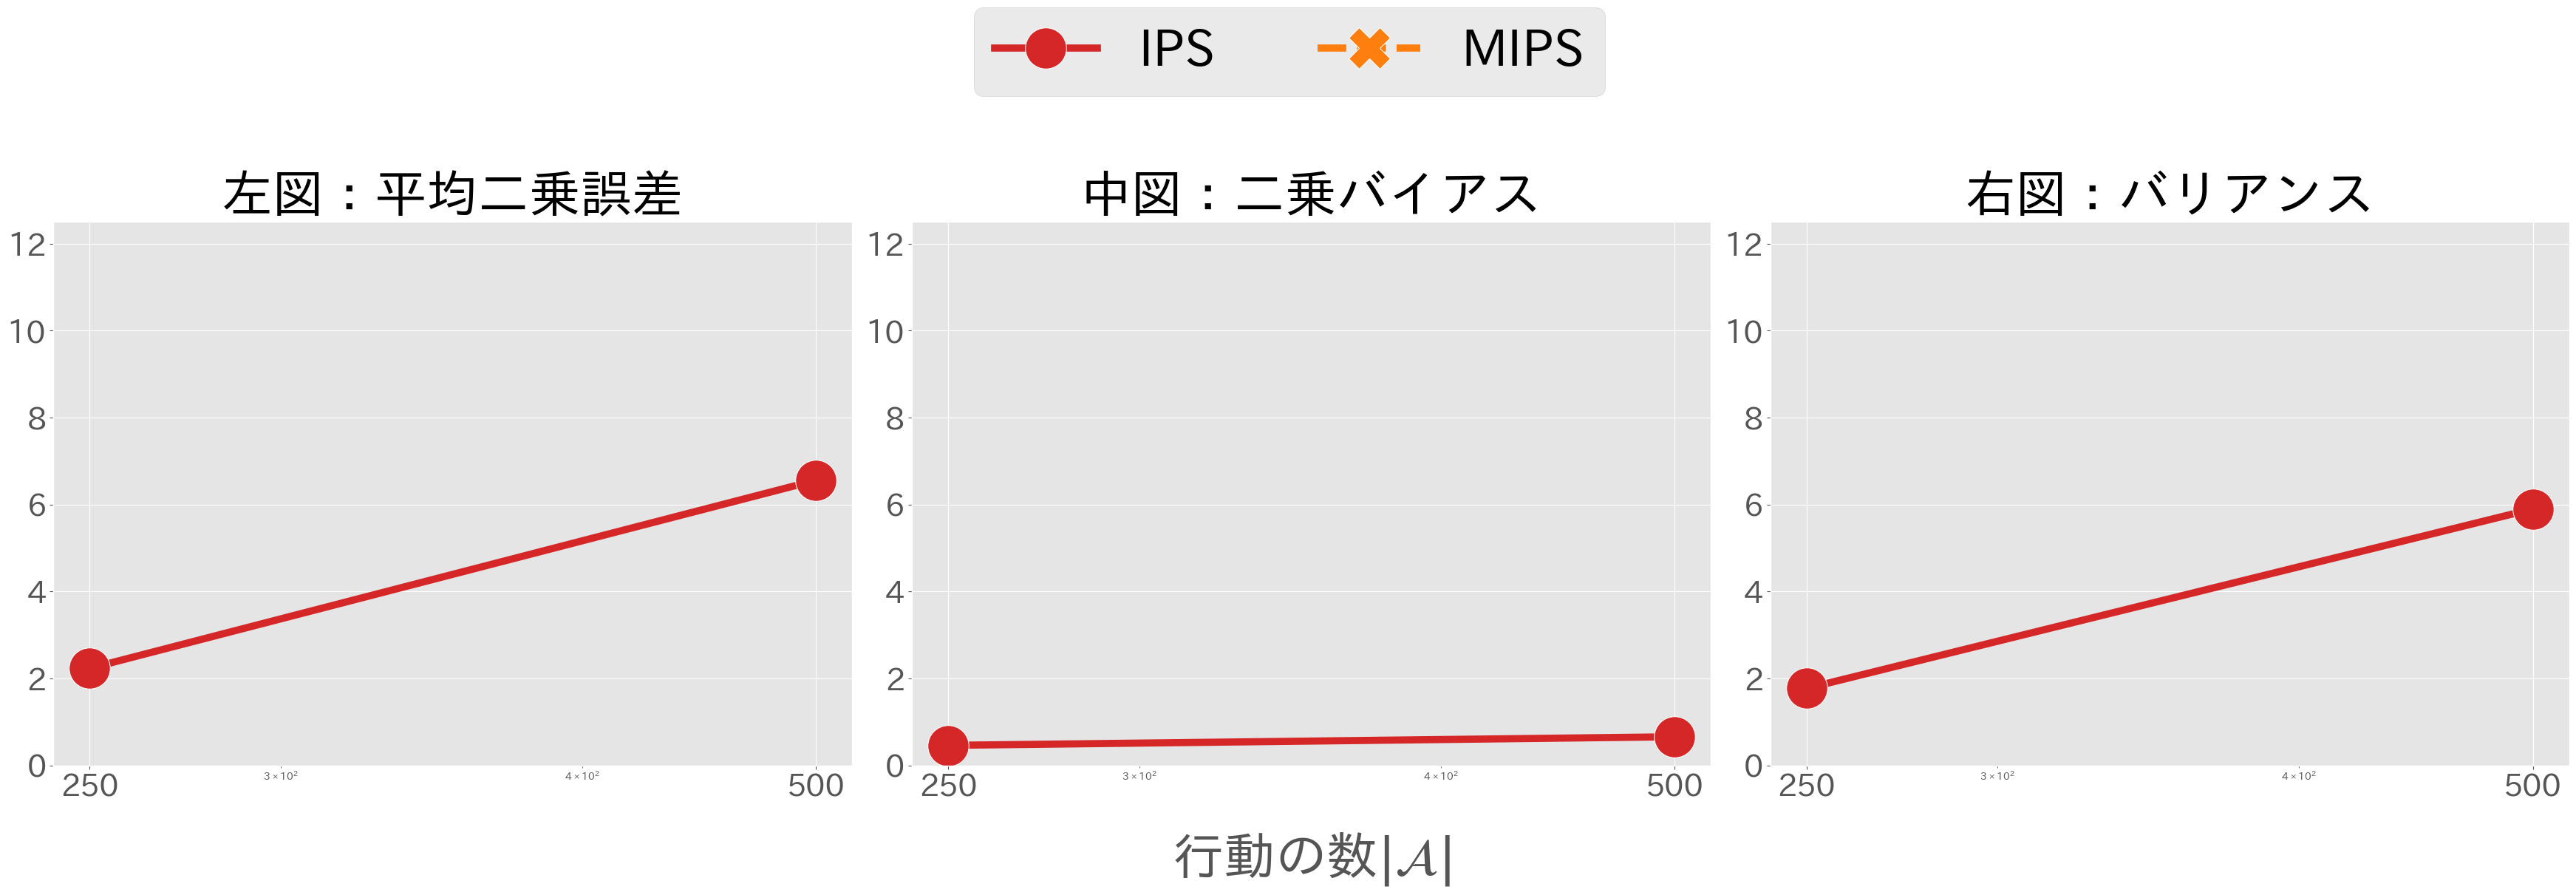

In [238]:
fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=7,
        legend=False,
        style="est",
        x="num_actions",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        palette=["tab:red", "tab:orange"],
        data=result_df_actions.query("est == 'ips' or est == 'mips'"),
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 12.5)
    ax.set_yticks([0, 2, 4, 6, 8, 10, 12])
    ax.tick_params(axis="y", labelsize=30)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    ax.set_xscale("log")
    if i == 1:
        ax.set_xlabel(r"行動の数$|\mathcal{A}|$", fontsize=50)
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(num_actions_list)
    ax.set_xticklabels(num_actions_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(["IPS", "MIPS"], fontsize=50, bbox_to_anchor=(0.5, 1.15), ncol=4, loc="center")